In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
! pip install yfinance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    mean_squared_error,
    auc,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

In [ ]:
import yfinance as yf

xmr = yf.Ticker("XMR-USD")
df_xmr = yf.download(tickers="XMR-USD", period="max", interval="1d")

# btc = yf.Ticker("BTC-USD")
# df_btc = yf.download(tickers="BTC-USD", period="max", interval="1d")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df_xmr

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600
2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000
2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000
2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000
2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000
...,...,...,...,...,...,...
2023-10-14,153.583801,154.282990,151.850967,152.833160,152.833160,33344438
2023-10-15,152.833466,153.465881,152.173126,152.448990,152.448990,31895675
2023-10-16,152.437531,153.522949,151.155411,152.544098,152.544098,64382308


In [ ]:
df_xmr.shift(-1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,121.344002,121.665001,101.757004,105.585999,105.585999,84614000.0
2017-11-10,105.750000,127.106003,103.877998,119.615997,119.615997,107708000.0
2017-11-11,119.597000,133.675003,110.617996,123.856003,123.856003,144948000.0
2017-11-12,128.960007,136.528000,120.921997,123.402000,123.402000,116200000.0
2017-11-13,123.615997,124.200996,118.625999,122.352997,122.352997,53544800.0
...,...,...,...,...,...,...
2023-10-14,152.833466,153.465881,152.173126,152.448990,152.448990,31895675.0
2023-10-15,152.437531,153.522949,151.155411,152.544098,152.544098,64382308.0
2023-10-16,152.532791,152.532791,149.571411,150.522949,150.522949,59794609.0


# Make Label


In [ ]:
df_xmr["Close_difference"] = df_xmr["Close"].shift(-1) - df_xmr["Close"]
df = df_xmr.copy()

##### method1


In [ ]:
df["Label"] = (df["Close_difference"] > 0).astype(int)
df.drop("Close_difference", axis=1, inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume,Label
Date,,,,,,,
2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600,0
2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000,1
2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000,1
2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000,0
2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000,0
...,...,...,...,...,...,...,...
2023-10-14,153.583801,154.282990,151.850967,152.833160,152.833160,33344438,0
2023-10-15,152.833466,153.465881,152.173126,152.448990,152.448990,31895675,1
2023-10-16,152.437531,153.522949,151.155411,152.544098,152.544098,64382308,0


##### method2


In [ ]:
# def make_target(row):
#     diff = row["Close_difference"]
#     n = 1
#     if diff >= n:
#         return 1
#     if diff <= -n:
#         return -1
#     return 0


# df["Label"] = df.apply(make_target, axis=1)
# df.drop("Close_difference", axis=1, inplace=True)
# df

In [ ]:
df = df.reset_index(drop=False)
df

,Date,Open,High,Low,Close,Adj Close,Volume,Label
0,2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600,0
1,2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000,1
2,2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000,1
3,2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000,0
4,2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000,0
...,...,...,...,...,...,...,...,...
2165,2023-10-14,153.583801,154.282990,151.850967,152.833160,152.833160,33344438,0
2166,2023-10-15,152.833466,153.465881,152.173126,152.448990,152.448990,31895675,1
2167,2023-10-16,152.437531,153.522949,151.155411,152.544098,152.544098,64382308,0
2168,2023-10-17,152.532791,152.532791,149.571411,150.522949,150.522949,59794609,1


### Change Features


In [ ]:
df["Variance"] = df["High"] - df["Low"]
df

,Date,Open,High,Low,Close,Adj Close,Volume,Label,Variance
0,2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600,0,11.185997
1,2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000,1,19.907997
2,2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000,1,23.228004
3,2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000,0,23.057007
4,2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000,0,15.606003
...,...,...,...,...,...,...,...,...,...
2165,2023-10-14,153.583801,154.282990,151.850967,152.833160,152.833160,33344438,0,2.432022
2166,2023-10-15,152.833466,153.465881,152.173126,152.448990,152.448990,31895675,1,1.292755
2167,2023-10-16,152.437531,153.522949,151.155411,152.544098,152.544098,64382308,0,2.367538
2168,2023-10-17,152.532791,152.532791,149.571411,150.522949,150.522949,59794609,1,2.961380


In [ ]:
df.drop(columns=["Open", "High", "Low", "Adj Close"], inplace=True)
df

,Date,Close,Volume,Label,Variance
0,2017-11-09,120.779999,86864600,0,11.185997
1,2017-11-10,105.585999,84614000,1,19.907997
2,2017-11-11,119.615997,107708000,1,23.228004
3,2017-11-12,123.856003,144948000,0,23.057007
4,2017-11-13,123.402000,116200000,0,15.606003
...,...,...,...,...,...
2165,2023-10-14,152.833160,33344438,0,2.432022
2166,2023-10-15,152.448990,31895675,1,1.292755
2167,2023-10-16,152.544098,64382308,0,2.367538
2168,2023-10-17,150.522949,59794609,1,2.961380


# Divide Our Data


In [ ]:
# def train_test_split_by_date(
#     df: pd.DataFrame,
#     start_date_train: str,
#     end_date_train: str,
#     start_date_test: str,
#     end_date_test: str,
#     divide_X_y: bool = True,
# ):
#     df_train = df[
#         (df["Date"] >= start_date_train) & (df["Date"] <= end_date_train)
#     ].reset_index(drop=True)

#     df_test = df[
#         (df["Date"] >= start_date_test) & (df["Date"] <= end_date_test)
#     ].reset_index(drop=True)

#     if divide_X_y:
#         X_train = df_train.drop(columns=["Label"])
#         y_train = df_train["Label"]

#         X_test = df_test.drop(columns=["Label"])
#         y_test = df_test["Label"]
#         return X_train, X_test, y_train, y_test

#     return df_train, df_test

In [ ]:
def train_test_split_by_date(
    df: pd.DataFrame,
    start_date_train: str,
    end_date_train: str,
    start_date_test: str,
    end_date_test: str,
    divide_X_y: bool = True,
    test: bool = True,
):
    df_train = df[
        (df["Date"] >= start_date_train) & (df["Date"] <= end_date_train)
    ].reset_index(drop=True)

    df_test = df[
        (df["Date"] >= start_date_test) & (df["Date"] <= end_date_test)
    ].reset_index(drop=True)

    if divide_X_y:
        X_train = df_train.drop(columns=["Label"])
        y_train = df_train["Label"]
        if test:
            X_test = df_test.drop(columns=["Label"])
            y_test = df_test["Label"]
            return X_train, X_test, y_train, y_test
        return X_train, y_train

    return df_train, df_test

In [ ]:
start_date_train_test = "2017-11-09"
end_date_train_test = "2023-10-07"

df_train_test = df[
    (df["Date"] >= start_date_train_test) & (df["Date"] <= end_date_train_test)
].reset_index(drop=True)
df_train_test

,Date,Close,Volume,Label,Variance
0,2017-11-09,120.779999,86864600,0,11.185997
1,2017-11-10,105.585999,84614000,1,19.907997
2,2017-11-11,119.615997,107708000,1,23.228004
3,2017-11-12,123.856003,144948000,0,23.057007
4,2017-11-13,123.402000,116200000,0,15.606003
...,...,...,...,...,...
2154,2023-10-03,147.151352,49389643,1,2.639694
2155,2023-10-04,150.469055,59400400,0,4.761566
2156,2023-10-05,149.623718,55704972,1,2.762878
2157,2023-10-06,151.992264,49535004,1,4.027649


# Divide Test Data


In [ ]:
start_date_train_val = "2017-11-09"
end_date_train_val = "2023-09-07"

start_date_test = "2023-09-08"
end_date_test = "2023-10-07"

df_train_val, df_test = train_test_split_by_date(
    df,
    start_date_train_val,
    end_date_train_val,
    start_date_test,
    end_date_test,
    divide_X_y=False,
)
df_test

,Date,Close,Volume,Label,Variance
0,2023-09-08,143.886154,46927009,0,3.195389
1,2023-09-09,143.406815,35896666,0,1.677582
2,2023-09-10,142.894440,33705148,0,1.965088
3,2023-09-11,139.930466,58031716,1,5.441772
4,2023-09-12,140.804672,57433672,1,3.567017
5,2023-09-13,143.115967,54374646,1,4.085739
6,2023-09-14,146.329483,44084896,1,4.750565
7,2023-09-15,147.350723,57280169,0,2.792572
8,2023-09-16,144.624649,34872985,1,3.754654
9,2023-09-17,145.797852,31255846,0,2.700851


# Plots


### Stock Chart Plot


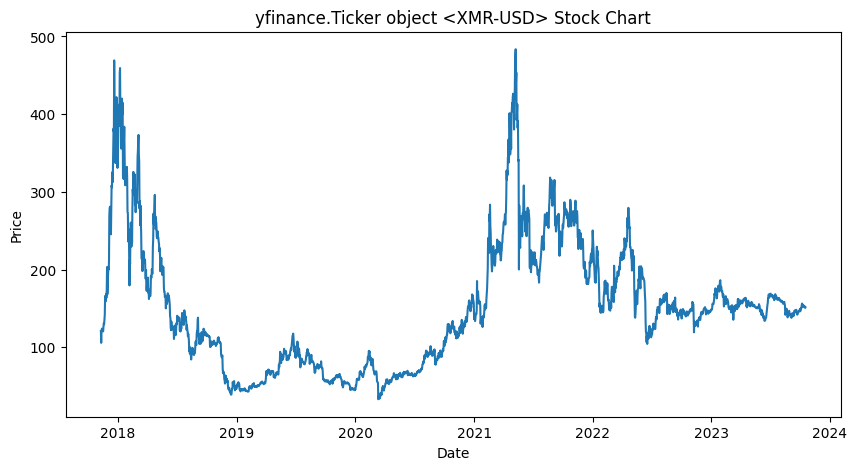

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df_xmr["Close"])
plt.title(f"{xmr} Stock Chart")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

### candlestick


In [ ]:
! pip install mplfinance

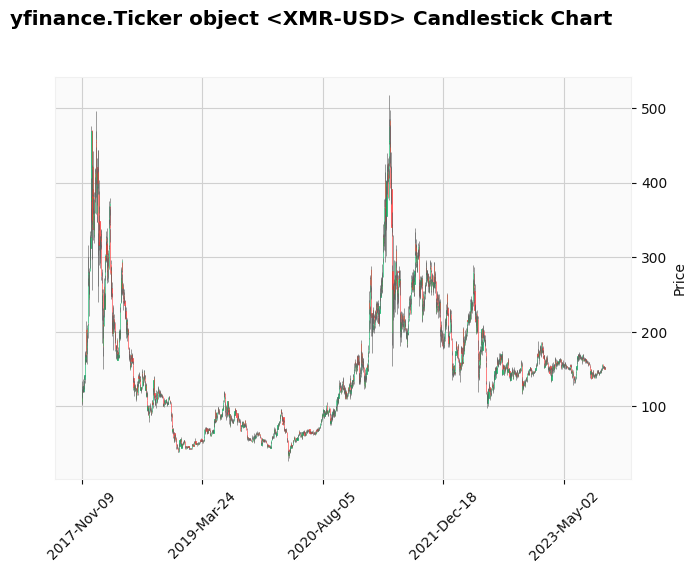

In [ ]:
import mplfinance as mpf

mpf.plot(df_xmr, type="candle", style="yahoo", title=f"{xmr} Candlestick Chart")

# Feature Engineering


### Check Missing Values


In [ ]:
df_train_val.isna().sum()

Date        0
Close       0
Volume      0
Label       0
Variance    0
dtype: int64

### Outlier


##### drop ountliers, Z-Score method


In [ ]:
def drop_outliers_zScore(data, threshold=3):
    z_scores = (data.iloc[:, :-1] - data.iloc[:, :-1].mean()) / data.iloc[:, :-1].std()
    print((np.abs(z_scores) < threshold).all(axis=1).sum())
    filtered_data = data[(np.abs(z_scores) < threshold).all(axis=1)]
    return filtered_data

In [ ]:
# drop_outliers_zScore(df_train_val)

##### drop outliers with LocalOutlierFactor


In [ ]:
from sklearn.neighbors import LocalOutlierFactor


def drop_outliers_LOF(data: pd.DataFrame):
    clf = LocalOutlierFactor(n_neighbors=10, contamination=0.05)  # 0.03, 0.05

    # Fit the data to the model
    y_pred = clf.fit_predict(data.iloc[:, :-1])

    # Identify the outliers
    outliers = np.where(y_pred == -1)

    return data.drop(outliers[0])

In [ ]:
# df_train_val.reset_index(drop=False)

In [ ]:
df_train_val.reset_index(drop=False).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   index     2129 non-null   int64         
 1   Date      2129 non-null   datetime64[ns]
 2   Close     2129 non-null   float64       
 3   Volume    2129 non-null   int64         
 4   Label     2129 non-null   int64         
 5   Variance  2129 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 99.9 KB


In [ ]:
drop_outliers_LOF(df_train_val.reset_index(drop=False).drop("Date", axis=1))

,index,Close,Volume,Label,Variance
0,0,120.779999,86864600,0,11.185997
1,1,105.585999,84614000,1,19.907997
2,2,119.615997,107708000,1,23.228004
3,3,123.856003,144948000,0,23.057007
4,4,123.402000,116200000,0,15.606003
...,...,...,...,...,...
2124,2124,140.839981,49564266,1,2.094498
2125,2125,141.170868,63835398,0,2.993912
2126,2126,137.781372,54468002,1,3.625900
2127,2127,142.113235,67734044,1,5.009445


# چون داده هامون سری زمانی هستن داده پرت پیدا کردن معنی نداره فکرکنم


### Split Train and Validation Data


In [ ]:
# start_date_train = "2017-11-09"
# end_date_train = "2023-08-07"

# start_date_val = "2023-08-08"
# end_date_val = "2023-09-07"

# df_train = df_train_val[
#     (df_train_val["Date"] >= start_date_train)
#     & (df_train_val["Date"] <= end_date_train)
# ].reset_index(drop=True)

# df_validation = df_train_val[
#     (df_train_val["Date"] >= start_date_val) & (df_train_val["Date"] <= end_date_val)
# ].reset_index(drop=True)

# X_train = df_train.drop(columns=["Label"])
# y_train = df_train["Label"]

# X_validation = df_validation.drop(columns=["Label"])
# y_validation = df_validation["Label"]

In [ ]:
start_date_train = "2017-11-09"
end_date_train = "2023-06-07"

start_date_val = "2023-06-08"
end_date_val = "2023-09-07"

X_train, X_validation, y_train, y_validation = train_test_split_by_date(
    df_train_val,
    start_date_train,
    end_date_train,
    start_date_val,
    end_date_val,
    divide_X_y=True,
)

In [ ]:
X_train.head()

,Date,Close,Volume,Variance
0,2017-11-09,120.779999,86864600,11.185997
1,2017-11-10,105.585999,84614000,19.907997
2,2017-11-11,119.615997,107708000,23.228004
3,2017-11-12,123.856003,144948000,23.057007
4,2017-11-13,123.402000,116200000,15.606003


In [ ]:
X_validation.head()

,Date,Close,Volume,Variance
0,2023-06-08,142.660126,56664638,3.377151
1,2023-06-09,143.050003,52539231,2.429214
2,2023-06-10,137.812439,92419685,15.922714
3,2023-06-11,138.158829,39307804,3.207825
4,2023-06-12,140.197021,77701627,4.929169


In [ ]:
f1_score(y_validation, y_validation.shift(1).fillna(0))

0.5333333333333333

In [ ]:
f1_score(y_validation, y_validation.shift(1).fillna(1))

0.5471698113207547

### Plot Distributions


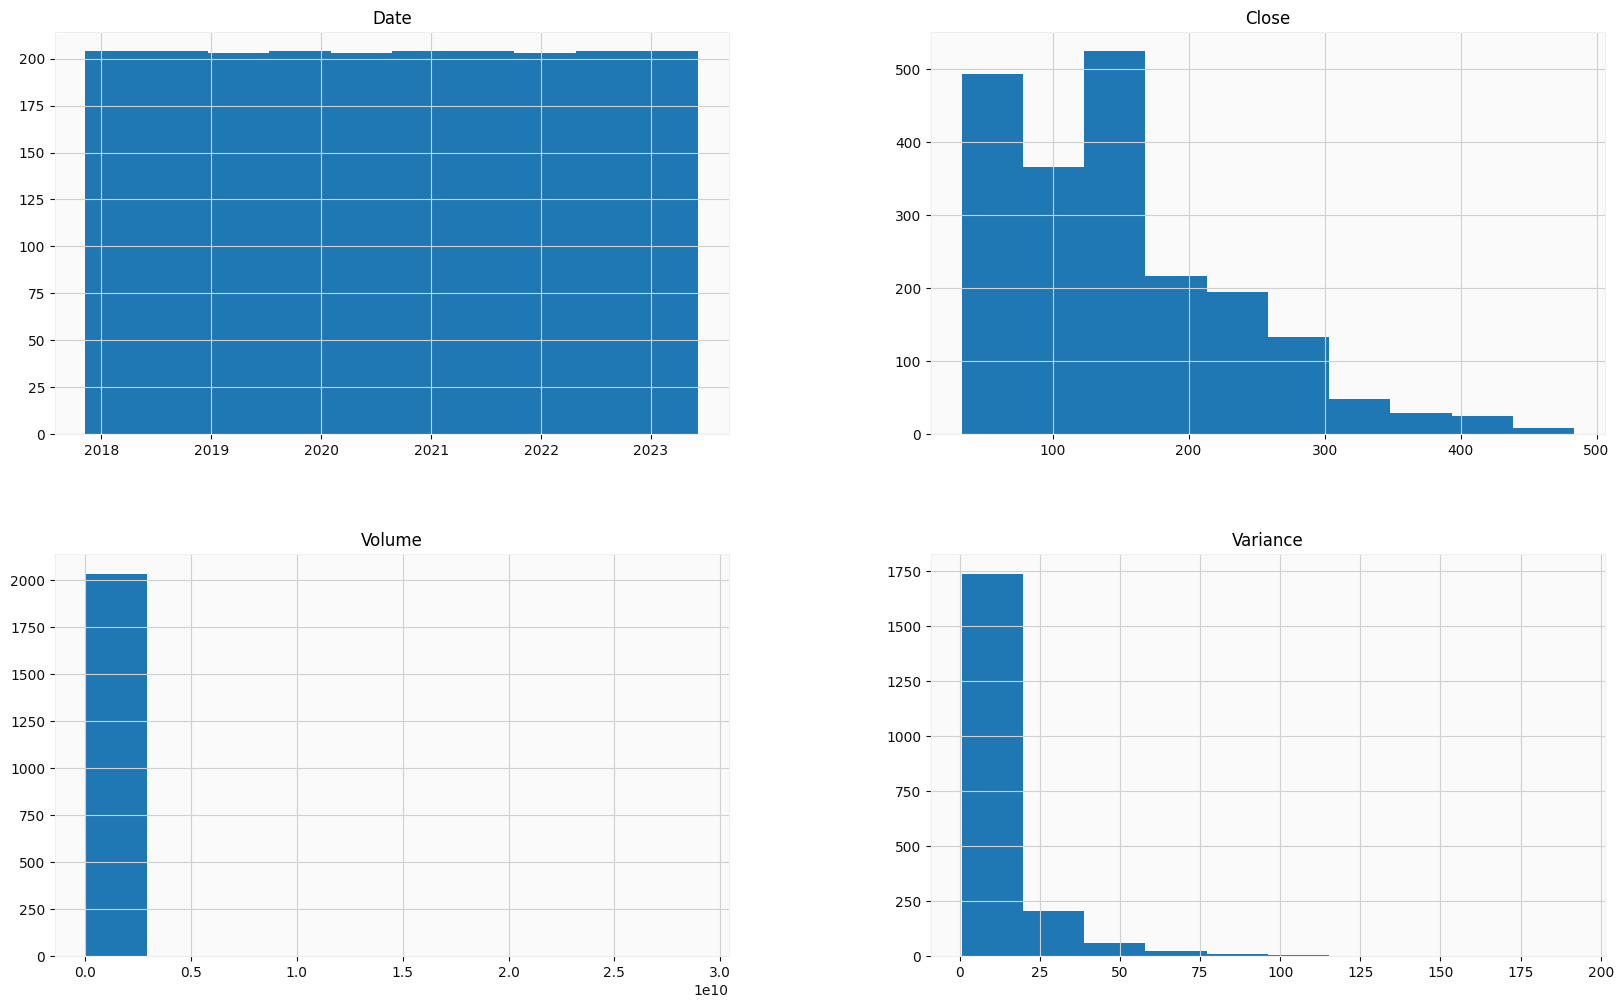

In [ ]:
X_train.hist(figsize=[20, 12])
plt.show()

In [ ]:
X_train.describe()

,Close,Volume,Variance
count,2037.000000,2.037000e+03,2037.000000
mean,149.895335,2.542309e+08,11.652186
std,83.999876,1.028817e+09,14.563935
min,33.010323,1.016030e+07,0.610867
25%,79.704430,6.595855e+07,3.583393
50%,142.323288,1.066830e+08,7.223503
75%,198.738998,1.967663e+08,13.692032
max,483.583618,2.895912e+10,191.717880


### Normalizing


##### method 1 : Standard Scaler


In [ ]:
X_train_normalized_ss = X_train.copy()
X_validation_normalized_ss = X_validation.copy()

scaler_ss = StandardScaler()
cols = X_train.drop(columns=["Date"]).columns
X_train_normalized_ss[cols] = scaler_ss.fit_transform(X_train_normalized_ss[cols])
X_validation_normalized_ss[cols] = scaler_ss.transform(X_validation_normalized_ss[cols])

In [ ]:
X_train_normalized_ss.describe()

,Close,Volume,Variance
count,2037.000000,2037.000000,2.037000e+03
mean,0.000000,0.000000,-2.790546e-17
std,1.000246,1.000246,1.000246e+00
min,-1.391832,-0.237293,-7.583136e-01
25%,-0.835812,-0.183044,-5.541616e-01
50%,-0.090166,-0.143450,-3.041603e-01
75%,0.581616,-0.055869,1.400959e-01
max,3.973461,27.907736,1.236684e+01


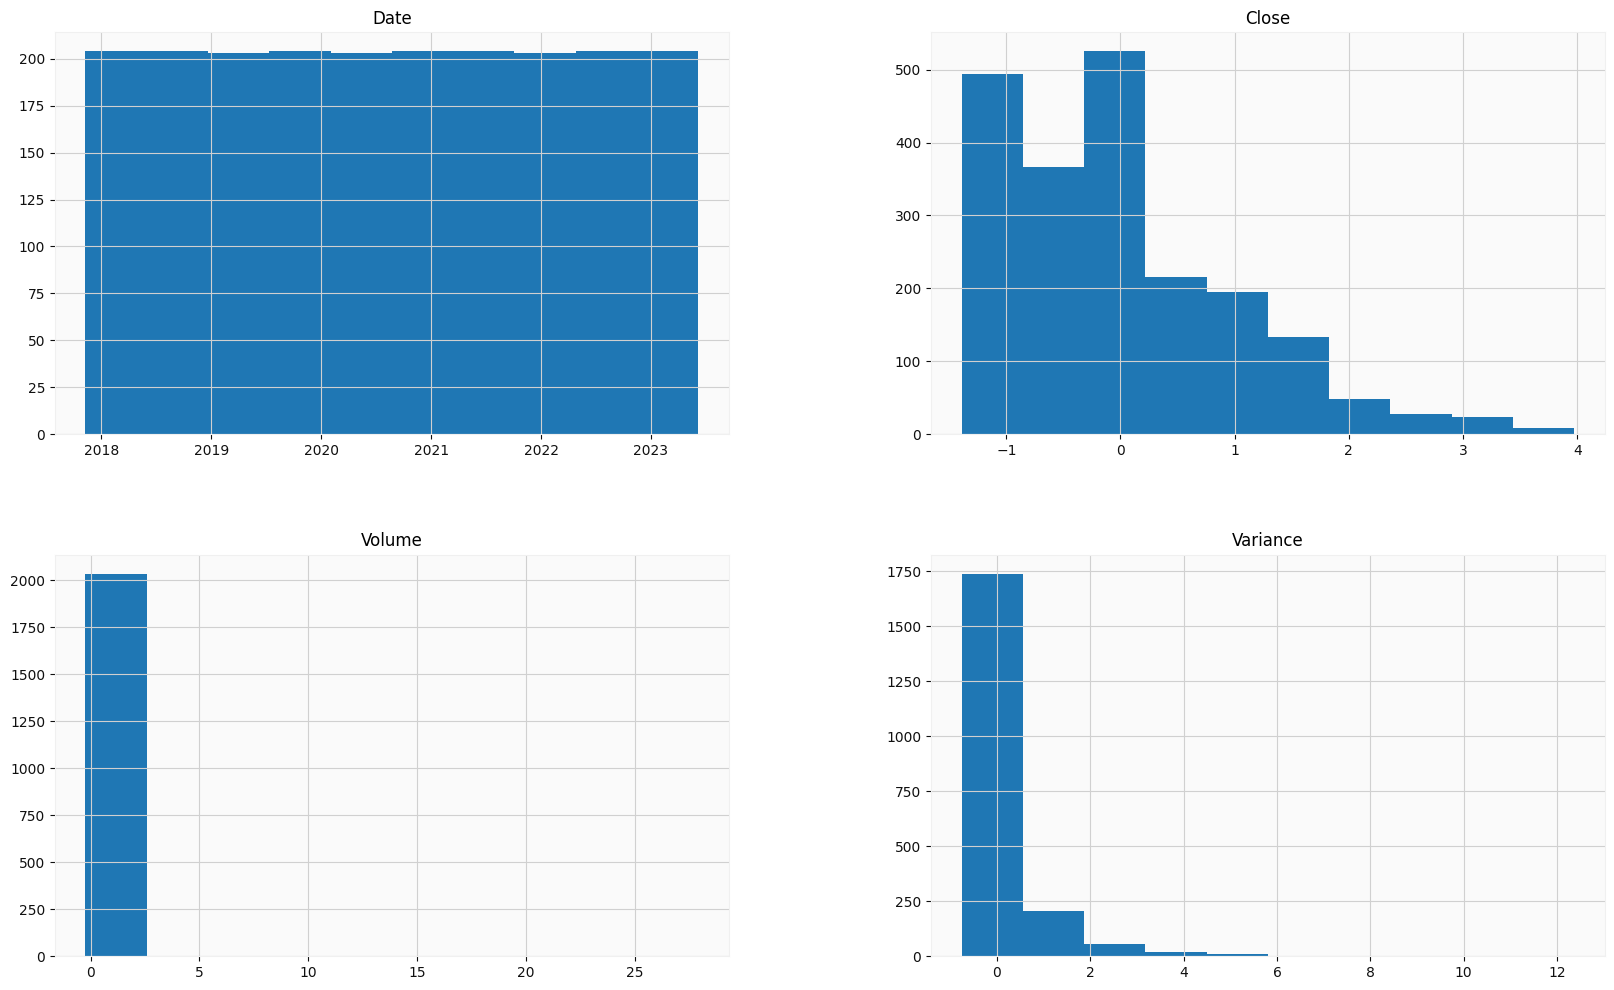

In [ ]:
X_train_normalized_ss.hist(figsize=[20, 12])
plt.show()

##### method 2 : Power Transform


In [ ]:
X_train_transformed = X_train.copy()
X_validation_transformed = X_validation.copy()

power_transformer = PowerTransformer(method="yeo-johnson", standardize=True)

cols = X_train.drop(columns=["Date"]).columns

X_train_transformed[cols] = power_transformer.fit_transform(X_train_transformed[cols])
X_validation_transformed[cols] = power_transformer.transform(
    X_validation_transformed[cols]
)

In [ ]:
X_train_transformed.describe()

,Close,Volume,Variance
count,2.037000e+03,2.037000e+03,2.037000e+03
mean,-1.116218e-16,-1.088313e-14,3.069600e-16
std,1.000246e+00,1.000246e+00,1.000246e+00
min,-2.211691e+00,-2.819797e+00,-2.491462e+00
25%,-8.342388e-01,-5.256164e-01,-7.677758e-01
50%,1.540727e-01,-3.308889e-02,2.600074e-02
75%,7.534815e-01,5.444954e-01,7.129205e-01
max,2.462102e+00,3.705187e+00,2.844513e+00


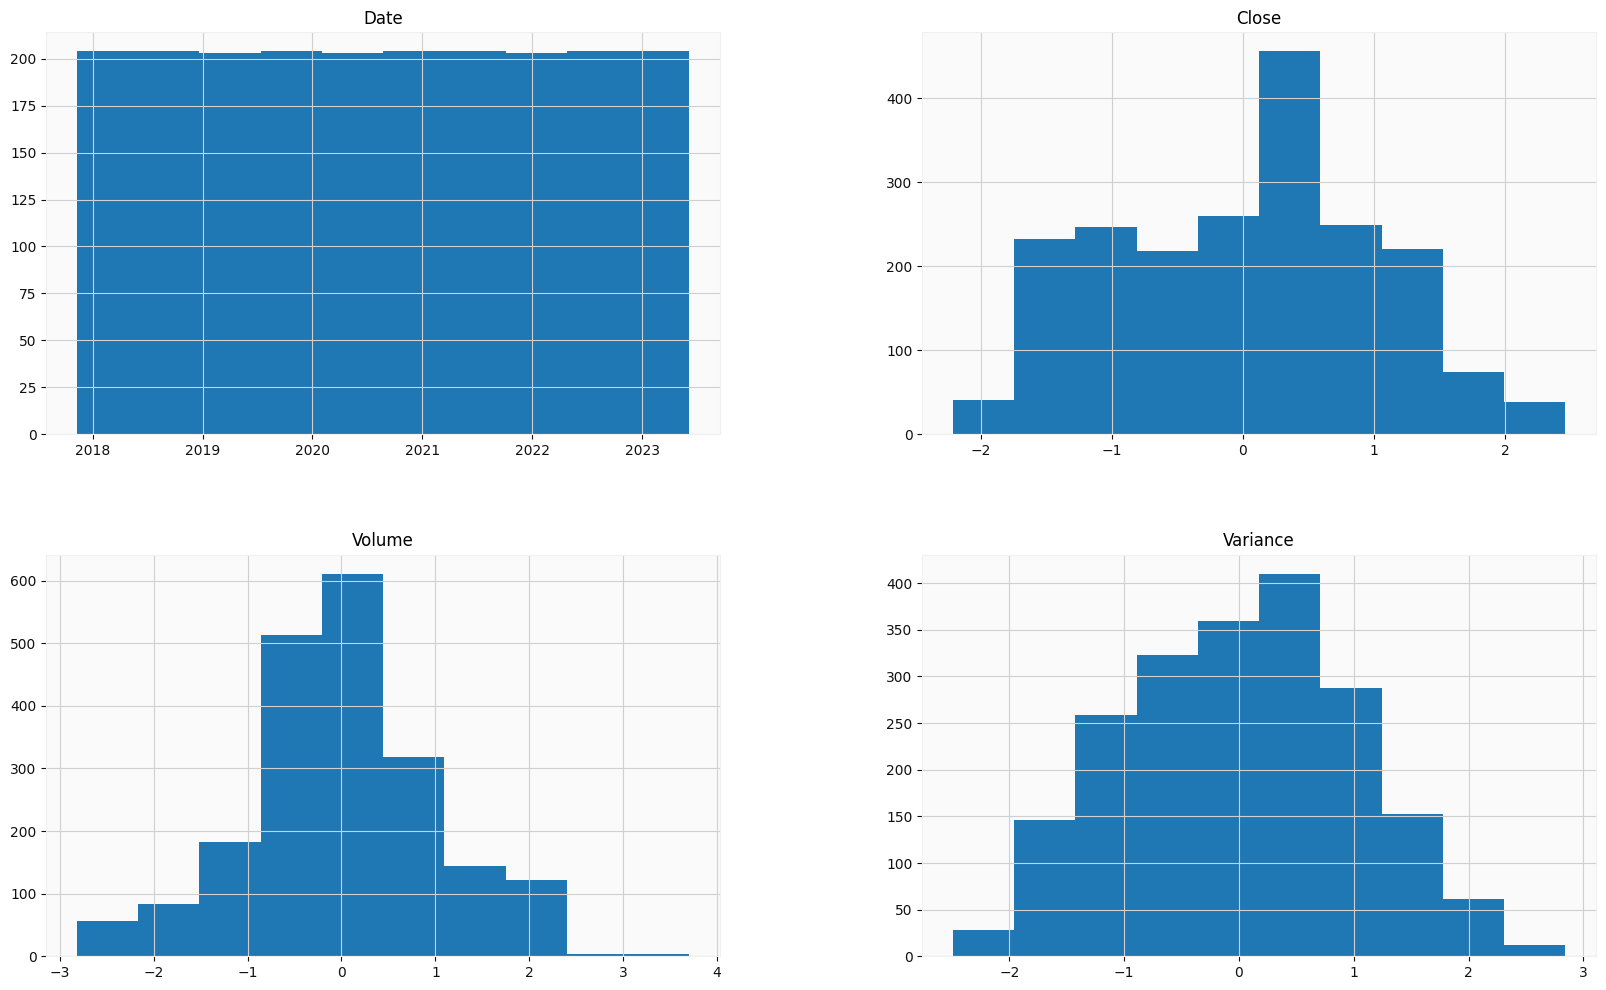

In [ ]:
X_train_transformed.hist(figsize=[20, 12])
plt.show()

##### method 3 : Min Max Scaler


In [ ]:
X_train_normalized_ms = X_train.copy()
X_validation_normalized_ms = X_validation.copy()

scaler_min_max = StandardScaler()
cols = X_train.drop(columns=["Date"]).columns
X_train_normalized_ms[cols] = scaler_min_max.fit_transform(X_train_normalized_ms[cols])
X_validation_normalized_ms[cols] = scaler_min_max.transform(
    X_validation_normalized_ms[cols]
)

In [ ]:
X_train_normalized_ms.describe()

,Close,Volume,Variance
count,2037.000000,2037.000000,2.037000e+03
mean,0.000000,0.000000,-2.790546e-17
std,1.000246,1.000246,1.000246e+00
min,-1.391832,-0.237293,-7.583136e-01
25%,-0.835812,-0.183044,-5.541616e-01
50%,-0.090166,-0.143450,-3.041603e-01
75%,0.581616,-0.055869,1.400959e-01
max,3.973461,27.907736,1.236684e+01


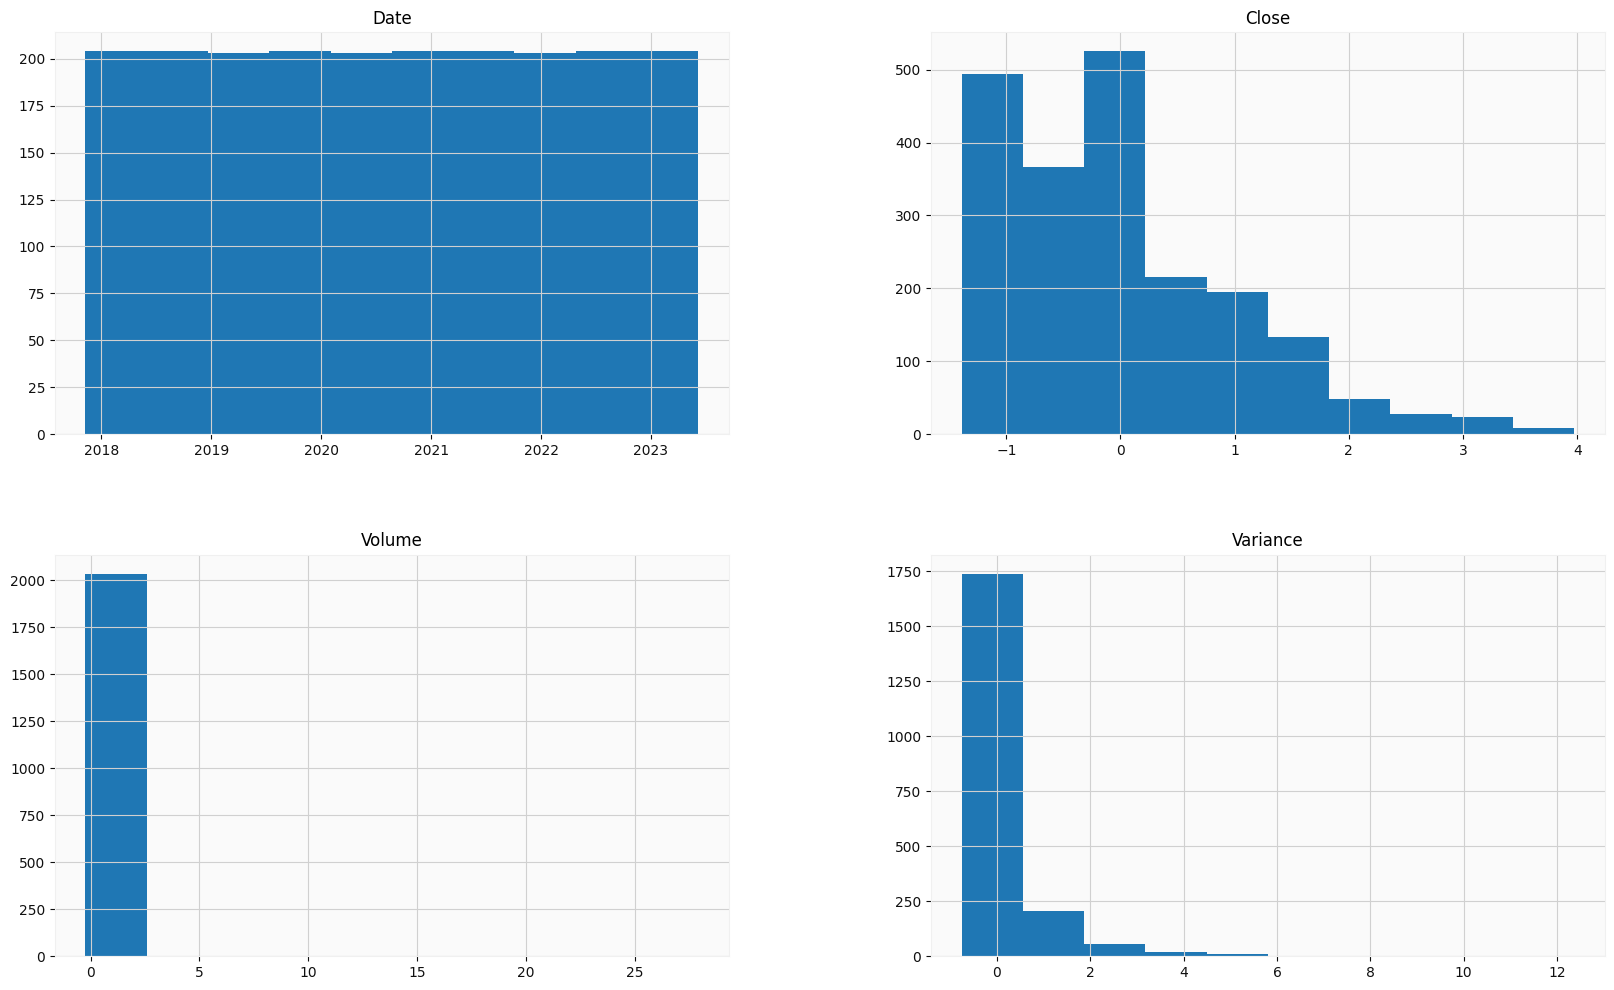

In [ ]:
X_train_normalized_ms.hist(figsize=[20, 12])
plt.show()

In [ ]:
df_train_val.corr()

,Close,Volume,Label,Variance
Close,1.000000,0.049219,-0.015416,0.671699
Volume,0.049219,1.000000,0.012916,0.083045
Label,-0.015416,0.012916,1.000000,-0.008214
Variance,0.671699,0.083045,-0.008214,1.000000


# Modeling and Evaluating


In [ ]:
def normalization(X_train, X_test, method):
    X_train_normalized = X_train.copy()
    X_test_normalized = X_test.copy()

    if method == "StandardScaler":
        ss = StandardScaler()
        X_train_normalized[X_train.columns] = ss.fit_transform(X_train[X_train.columns])
        X_test_normalized[X_test.columns] = ss.transform(X_test[X_test.columns])

    if method == "MinMaxScaler":
        ms = MinMaxScaler()
        X_train_normalized[X_train.columns] = ms.fit_transform(X_train[X_train.columns])
        X_test_normalized[X_test.columns] = ms.transform(X_test[X_test.columns])

    if method == "PowerTransformer":
        pt = PowerTransformer()
        X_train_normalized[X_train.columns] = pt.fit_transform(X_train[X_train.columns])
        X_test_normalized[X_test.columns] = pt.transform(X_test[X_test.columns])

    return X_train_normalized, X_test_normalized

In [ ]:
def evaluation(y_true, y_pred, df_evaluation, df_confusion, model_name):
    # Evaluate
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred)

    new_record_evaluation = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc_score,
        "MSE": mse,
    }

    df_evaluation.loc[model_name] = new_record_evaluation

    # Confusion matrix

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # tp = np.sum((y_true == 1) & (y_pred == 1))
    # tn = np.sum((y_true == 0) & (y_pred == 0))
    # fp = np.sum((y_true == 0) & (y_pred == 1))
    # fn = np.sum((y_true == 1) & (y_pred == 0))

    new_record_confusion = {
        "tp": confusion[1, 1],
        "tn": confusion[0, 0],
        "fp": confusion[0, 1],
        "fn": confusion[1, 0],
    }

    df_confusion.loc[model_name] = new_record_confusion

    print(confusion)
    print(new_record_evaluation)

    return df_evaluation, df_confusion

In [ ]:
def model_predict(
    df_train_val,
    model,
    test_item,
    normalize=False,
    start_date_train="2017-11-09",
    start_date_val="2023-08-08",
    end_date_val="2023-09-07",
):
    from datetime import date, timedelta

    test_item_date = test_item.Date.date()

    end_date_train = (test_item_date - timedelta(days=1)).strftime("%Y-%m-%d")

    X_train, y_train = train_test_split_by_date(
        df_train_val,
        start_date_train,
        end_date_train,
        start_date_val,
        end_date_val,
        divide_X_y=True,
        test=False,
    )

    X_train = X_train.drop("Date", axis=1)
    X_test = (test_item[1:].to_frame().T).astype(float)

    # Normalized
    # if normalize:
    X_train, X_test = normalization(X_train, X_test, method="PowerTransformer")

    # Train model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    return y_pred

### Define Evaluation Matrixes


In [ ]:
df_confusion_val = pd.DataFrame({}, columns=["tn", "fp", "fn", "tp"])
df_evaluation_val = pd.DataFrame(
    columns=["Accuracy", "Precision", "Recall", "F1 Score", "AUC", "MSE"]
)

### Logistic Regression


In [ ]:
def logestic_regression(df, X_test, y_test, df_evaluation, df_confusion):
    from sklearn.linear_model import LogisticRegression

    model_lr = LogisticRegression(C=1, penalty="l2")
    model_name = "Logistic Regression"

    df_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    df_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    model_new = model_lr
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(df, model, test_item, normalize=True)
        y_pred_list.append(y_val_pred[0])

    df_evaluation, df_confusion = evaluation(
        y_test.tolist(), y_pred_list, df_evaluation, df_confusion, model_name
    )

In [ ]:
y_pred_lr = logestic_regression(
    df_train_val, X_validation, y_validation, df_evaluation_val, df_confusion_val
)

[[ 0 39]
 [ 0 53]]
{'Accuracy': 0.5760869565217391, 'Precision': 0.5760869565217391, 'Recall': 1.0, 'F1 Score': 0.7310344827586206, 'AUC': 0.5, 'MSE': 0.42391304347826086}


ValueError: ignored

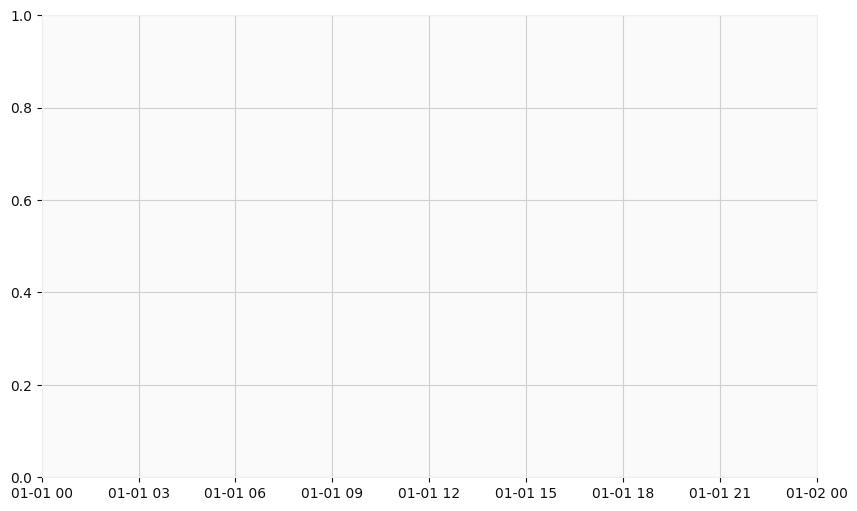

In [ ]:
Xc = X_validation[y_validation == y_pred_lr]
Xf = X_validation[y_validation != y_pred_lr]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation, marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation, marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

In [ ]:
Xc

In [ ]:
Xc.iloc[:, 0].shape

NameError: ignored

### Decision Tree


In [ ]:
def decision_tree_classifier(
    df, X_test, y_test, df_evaluation, df_confusion, max_depth
):
    from sklearn.tree import DecisionTreeClassifier

    model_dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    model_name = "Decision Tree"

    df_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    df_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    model_new = model_dt
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(df, model, test_item, normalize=False)
        y_pred_list.append(y_val_pred[0])

    df_evaluation, df_confusion = evaluation(
        y_test.tolist(), y_pred_list, df_evaluation, df_confusion, model_name
    )

In [ ]:
max_depth = 25
y_pred_dt = decision_tree_classifier(
    df_train_val,
    X_validation,
    y_validation,
    df_evaluation_val,
    df_confusion_val,
    max_depth,
)

[[15 24]
 [21 32]]
{'Accuracy': 0.5108695652173914, 'Precision': 0.5714285714285714, 'Recall': 0.6037735849056604, 'F1 Score': 0.5871559633027522, 'AUC': 0.4941944847605224, 'MSE': 0.4891304347826087}


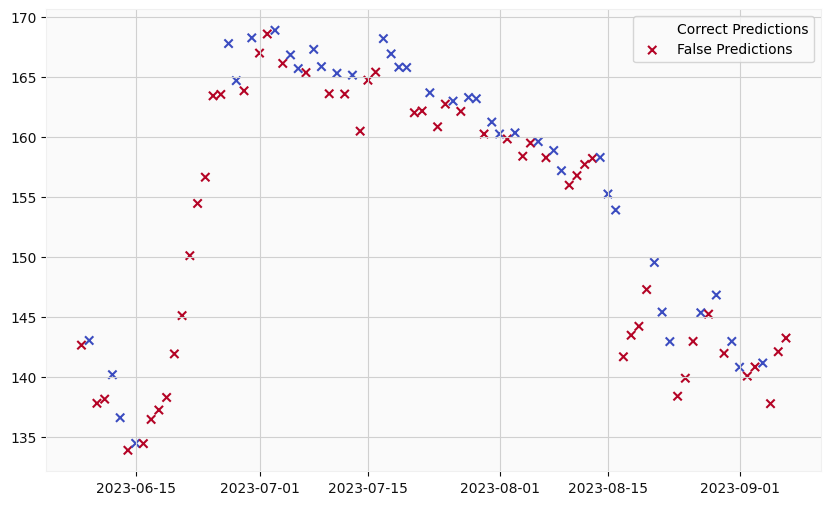

In [ ]:
Xc = X_validation[y_validation == y_pred_dt]
Xf = X_validation[y_validation != y_pred_dt]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation[y_validation == y_pred_dt], marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation[y_validation != y_pred_dt], marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

In [ ]:
Xc

,Date,Close,Volume,Variance


### SVM


In [ ]:
def svm(df, X_test, y_test, df_evaluation, df_confusion):
    from sklearn.svm import SVC

    model_svm = SVC()
    model_name = "SVM"

    df_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    df_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    # change Label 0 to -1
    # df["Label"] = df["Label"].replace({0: -1})
    # y_test = y_test.replace({0: -1})

    model_new = model_svm
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(df, model, test_item, normalize=False)
        y_pred_list.append(y_val_pred[0])

    df_evaluation, df_confusion = evaluation(
        y_test.tolist(), y_pred_list, df_evaluation, df_confusion, model_name
    )
    # print(y_pred_list)
    # print(y_test.tolist())

In [ ]:
y_pred_svm = svm(
    df_train_val.copy(), X_validation, y_validation, df_evaluation_val, df_confusion_val
)

In [ ]:
Xc = X_validation[y_validation == y_pred_svm]
Xf = X_validation[y_validation != y_pred_svm]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation[y_validation == y_pred_svm], marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation[y_validation != y_pred_svm], marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

### AdaBoost


In [ ]:
def ada_boost(df, X_test, y_test, df_evaluation, df_confusion):
    from sklearn.ensemble import AdaBoostClassifier

    model_ada = AdaBoostClassifier(random_state=42)
    model_name = "Ada Boost"

    df_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    df_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    model_new = model_ada
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(df, model, test_item, normalize=False)
        y_pred_list.append(y_val_pred[0])

    df_evaluation, df_confusion = evaluation(
        y_test.tolist(), y_pred_list, df_evaluation, df_confusion, model_name
    )

In [ ]:
y_pred_ab = ada_boost(df_train_val, X_validation, y_validation, df_evaluation_val, df_confusion_val)

In [ ]:
Xc = X_validation[y_validation == y_pred_ab]
Xf = X_validation[y_validation != y_pred_ab]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation[y_validation == y_pred_ab], marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation[y_validation != y_pred_ab], marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

### KNN


In [ ]:
def knn(
    df, X_test, y_test, df_evaluation, df_confusion, n_neighbors, metric="manhattan"
):
    from sklearn.neighbors import KNeighborsClassifier

    model_knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
    model_name = "KNN"

    df_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    df_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    model_new = model_knn
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(df, model, test_item, normalize=True)
        y_pred_list.append(y_val_pred[0])

    df_evaluation, df_confusion = evaluation(
        y_test.tolist(), y_pred_list, df_evaluation, df_confusion, model_name
    )

In [ ]:
n_neighbors = 5
metric = "minkowski"
y_pred_knn = knn(
    df_train_val,
    X_validation,
    y_validation,
    df_evaluation_val,
    df_confusion_val,
    n_neighbors,
    metric,
)

In [ ]:
Xc = X_validation[y_validation == y_pred_knn]
Xf = X_validation[y_validation != y_pred_knn]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation[y_validation == y_pred_knn], marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation[y_validation != y_pred_knn], marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

### Random Forest


In [ ]:
def random_forest_classifier(
    df, X_test, y_test, df_evaluation, df_confusion, max_depth, n_estimators
):
    from sklearn.ensemble import RandomForestClassifier

    model_rf = RandomForestClassifier(
        max_depth=max_depth,
        random_state=42,
        n_estimators=n_estimators,
    )
    model_name = "Random Forest"

    df_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    df_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    model_new = model_rf
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(df, model, test_item, normalize=False)
        y_pred_list.append(y_val_pred[0])

    df_evaluation, df_confusion = evaluation(
        y_test.tolist(), y_pred_list, df_evaluation, df_confusion, model_name
    )

In [ ]:
max_depth = 10
n_estimators = 100
y_pred_rfs = random_forest_classifier(
    df_train_val,
    X_validation,
    y_validation,
    df_evaluation_val,
    df_confusion_val,
    max_depth,
    n_estimators,
)

In [ ]:
Xc = X_validation[y_validation == y_pred_rfs]
Xf = X_validation[y_validation != y_pred_rfs]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation[y_validation == y_pred_rfs], marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation[y_validation != y_pred_rfs], marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

### Gausian


In [ ]:
def gaussian_nb(df, X_test, y_test, df_evaluation, df_confusion):
    from sklearn.naive_bayes import GaussianNB

    model_gnb = GaussianNB()
    model_name = "Gaussian NB"

    df_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    df_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    model_new = model_gnb
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(df, model, test_item, normalize=True)
        y_pred_list.append(y_val_pred[0])

    df_evaluation, df_confusion = evaluation(
        y_test.tolist(), y_pred_list, df_evaluation, df_confusion, model_name
    )

In [ ]:
y_pred = gaussian_nb(
    df_train_val, X_validation, y_validation, df_evaluation_val, df_confusion_val
)

In [ ]:
Xc = X_validation[y_validation == y_pred]
Xf = X_validation[y_validation != y_pred]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation[y_validation == y_pred], marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation[y_validation != y_pred], marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

### XGboost


In [ ]:
! pip install xgboost

In [ ]:
def xg_boost(df, X_test, y_test, df_evaluation, df_confusion):
    from xgboost import XGBClassifier

    model_xgb = XGBClassifier(random_state=42)
    model_name = "Xg Boost"

    df_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    df_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    model_new = model_xgb
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(df, model, test_item, normalize=False)
        y_pred_list.append(y_val_pred[0])

    df_evaluation, df_confusion = evaluation(
        y_test.tolist(), y_pred_list, df_evaluation, df_confusion, model_name
    )

In [ ]:
y_pred_xgb = xg_boost(df_train_val, X_validation, y_validation, df_evaluation_val, df_confusion_val)

In [ ]:
Xc = X_validation[y_validation == y_pred_xgb]
Xf = X_validation[y_validation != y_pred_xgb]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation[y_validation == y_pred_xgb], marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation[y_validation != y_pred_xgb], marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

### Staking Models


In [ ]:
! pip install mlxtend

In [ ]:
def stacking(df, X_test, y_test, df_evaluation, df_confusion):
    from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
    from xgboost import XGBClassifier
    from mlxtend.classifier import StackingClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC

    model_svm = SVC(probability=True)
    model_lr = LogisticRegression(C=1, penalty="l2")
    model_dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    model_rf = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=42)
    model_xgb = XGBClassifier(objective="binary:logistic", random_state=42)
    model_knn = KNeighborsClassifier(n_neighbors=12, metric="manhattan")
    model_adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)

    stacking_model = StackingClassifier(
        classifiers=[model_rf, model_knn],
        use_probas=True,
        meta_classifier=RandomForestClassifier(n_estimators=100, random_state=42),
    )

    model_name = "Stacking ()"

    df_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    df_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    model_new = stacking_model
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(df, model, test_item, normalize=False)
        y_pred_list.append(y_val_pred[0])

    df_evaluation, df_confusion = evaluation(
        y_test.tolist(), y_pred_list, df_evaluation, df_confusion, model_name
    )

In [ ]:
y_pred_s = stacking(df_train_val, X_validation, y_validation, df_evaluation_val, df_confusion_val)

In [ ]:
Xc = X_validation[y_validation == y_pred_s]
Xf = X_validation[y_validation != y_pred_s]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation[y_validation == y_pred_s], marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation[y_validation != y_pred_s], marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

In [ ]:
f1_score(y_validation, y_validation.shift(1).fillna(0))

In [ ]:
f1_score(y_validation, y_validation.shift(1).fillna(1))

In [ ]:
df_evaluation_val

In [ ]:
df_confusion_val

# Test


### Divide X, y


In [ ]:
X_test = df_test.drop(columns=["Label"])
y_test = df_test["Label"]

In [ ]:
df_confusion_test = pd.DataFrame({}, columns=["tn", "fp", "fn", "tp"])
df_evaluation_test = pd.DataFrame(
    columns=["Accuracy", "Precision", "Recall", "F1 Score", "AUC", "MSE"]
)

In [ ]:
y_pred_lr_t = logestic_regression(
    df_train_test, X_test, y_test, df_evaluation_test, df_confusion_test
)

In [ ]:
Xc = X_validation[y_validation == y_pred_lr_t]
Xf = X_validation[y_validation != y_pred_lr_t]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation[y_validation == y_pred_lr_t], marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation[y_validation != y_pred_lr_t], marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

In [ ]:
max_depth = 13
decision_tree_classifier(
    df_train_test,
    X_test,
    y_test,
    df_evaluation_test,
    df_confusion_test,
    max_depth,
)

In [ ]:
svm(df_train_test.copy(), X_test, y_test, df_evaluation_test, df_confusion_test)

In [ ]:
ada_boost(df_train_test, X_test, y_test, df_evaluation_test, df_confusion_test)

In [ ]:
n_neighbors = 5


metric = "manhattan"
knn(
    df_train_test,
    X_test,
    y_test,
    df_evaluation_test,
    df_confusion_test,
    n_neighbors,
    metric,
)

In [ ]:
max_depth = 13
n_estimators = 100
random_forest_classifier(
    df_train_test,
    X_test,
    y_test,
    df_evaluation_test,
    df_confusion_test,
    max_depth,
    n_estimators,
)

In [ ]:
gaussian_nb(df_train_test, X_test, y_test, df_evaluation_test, df_confusion_test)

In [ ]:
xg_boost(df_train_test, X_test, y_test, df_evaluation_test, df_confusion_test)

In [ ]:
stacking(df_train_test, X_test, y_test, df_evaluation_test, df_confusion_test)

In [ ]:
df_evaluation_test

In [ ]:
df_confusion_test

In [ ]:
f1_score(y_test, y_test.shift(1).fillna(0))

In [ ]:
y_test.value_counts()

# Add Extra Features

In [ ]:
btc = yf.Ticker("BTC-USD")
df_btc = yf.download(tickers = "BTC-USD", period = "max", interval = "1d")

In [ ]:
df_btc

In [ ]:
df

In [ ]:
data = df.copy()
data

In [ ]:
# Calculate the exponential moving average
data['EMA5'] = data['Close'].ewm(span=5).mean()
data

In [ ]:
# Calculate the simple moving average
data['SMA5'] = data['Close'].rolling(5).mean()
data

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean', add_indicator=False)
##X = imputer.fit_transform(X)
#X_train = imputer.fit_transform(X_train)
#X_test = imputer.transform(X_test)
data['SMA5'] = imputer.fit_transform(data[['SMA5']])
data

In [ ]:
data = data.merge(df_btc[["Close"]], on="Date", how="left").rename(columns={"Close_x": "Close", "Close_y": "Close_BTC"})
data

In [ ]:
data = data.dropna(axis=0)
data

In [ ]:
data['EMA5_BTC'] = data['Close_BTC'].ewm(span=5).mean()
data

In [ ]:
# Calculate the simple moving average
data['SMA5_BTC'] = data['Close_BTC'].rolling(5).mean()
data

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean', add_indicator=False)
##X = imputer.fit_transform(X)
#X_train = imputer.fit_transform(X_train)
#X_test = imputer.transform(X_test)
data['SMA5_BTC'] = imputer.fit_transform(data[['SMA5_BTC']])
data

In [ ]:
# Download the S&P 500 data
df_sp500 = yf.download(tickers = "^GSPC", period = "max", interval = "1d")

In [ ]:
df_sp500

In [ ]:
data = data.merge(df_sp500[["Close"]], on="Date", how="left").rename(columns={"Close_x": "Close", "Close_y": "Close_SP500"})
data

In [ ]:
data.isna().sum()/len(data)*100

In [ ]:
data.corr()

In [ ]:
data['Close_SP500'].mean()

In [ ]:
data = data.sort_values(['Date'])
# Cloud Coverage - interpolate
data['Close_SP500'] = data.groupby('Date')['Close_SP500'].apply(lambda x: x.interpolate(method='linear'))

In [ ]:
data

In [ ]:
data.isna().sum()/len(data)*100

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean', add_indicator=False)
##X = imputer.fit_transform(X)
#X_train = imputer.fit_transform(X_train)
#X_test = imputer.transform(X_test)
data['Close_SP500'] = imputer.fit_transform(data[['Close_SP500']])

In [ ]:
data

In [ ]:
# Download the gold data
df_gold = yf.download(tickers = "GC=F", period = "max", interval = "1d")
df_gold

In [ ]:
data = data.merge(df_gold[["Close"]], on="Date", how="left").rename(columns={"Close_x": "Close", "Close_y": "Close_gold"})
data

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean', add_indicator=False)
##X = imputer.fit_transform(X)
#X_train = imputer.fit_transform(X_train)
#X_test = imputer.transform(X_test)
data['Close_gold'] = imputer.fit_transform(data[['Close_gold']])
data

In [ ]:
data.corr()

In [ ]:
def train_test_split_by_date(
    df: pd.DataFrame,
    start_date_train: str,
    end_date_train: str,
    start_date_test: str,
    end_date_test: str,
    divide_X_y: bool = True,
    test: bool = True,
):
    data_train = data[
        (data["Date"] >= start_date_train) & (data["Date"] <= end_date_train)
    ].reset_index(drop=True)

    data_test = data[
        (data["Date"] >= start_date_test) & (data["Date"] <= end_date_test)
    ].reset_index(drop=True)

    if divide_X_y:
        X_train = data_train.drop(columns=["Label"])
        y_train = data_train["Label"]
        if test:
            X_test = data_test.drop(columns=["Label"])
            y_test = data_test["Label"]
            return X_train, X_test, y_train, y_test
        return X_train, y_train

    return data_train, data_test

In [ ]:
start_date_train_test = "2017-11-09"
end_date_train_test = "2023-10-07"

data_train_test = data[
    (data["Date"] >= start_date_train_test) & (data["Date"] <= end_date_train_test)
].reset_index(drop=True)
data_train_test

In [ ]:
start_date_train_val = "2017-11-09"
end_date_train_val = "2023-09-07"

start_date_test = "2023-09-08"
end_date_test = "2023-10-07"

data_train_val, data_test = train_test_split_by_date(
    data,
    start_date_train_val,
    end_date_train_val,
    start_date_test,
    end_date_test,
    divide_X_y=False,
)
data_test

In [ ]:
data_train_val.isna().sum()

In [ ]:
start_date_train = "2017-11-09"
end_date_train = "2023-06-07"

start_date_val = "2023-06-08"
end_date_val = "2023-09-07"

X_train, X_validation, y_train, y_validation = train_test_split_by_date(
    data_train_val,
    start_date_train,
    end_date_train,
    start_date_val,
    end_date_val,
    divide_X_y=True,
)

In [ ]:
def evaluation(y_true, y_pred, data_evaluation, data_confusion, model_name):
    # Evaluate
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred)

    new_record_evaluation = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc_score,
        "MSE": mse,
    }

    data_evaluation.loc[model_name] = new_record_evaluation

    # Confusion matrix

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # tp = np.sum((y_true == 1) & (y_pred == 1))
    # tn = np.sum((y_true == 0) & (y_pred == 0))
    # fp = np.sum((y_true == 0) & (y_pred == 1))
    # fn = np.sum((y_true == 1) & (y_pred == 0))

    new_record_confusion = {
        "tp": confusion[1, 1],
        "tn": confusion[0, 0],
        "fp": confusion[0, 1],
        "fn": confusion[1, 0],
    }

    data_confusion.loc[model_name] = new_record_confusion

    print(confusion)
    print(new_record_evaluation)

    return data_evaluation, data_confusion

In [ ]:
def model_predict(
    data_train_val,
    model,
    test_item,
    normalize=False,
    start_date_train="2017-11-09",
    start_date_val="2023-08-08",
    end_date_val="2023-09-07",
):
    from datetime import date, timedelta

    test_item_date = test_item.Date.date()

    end_date_train = (test_item_date - timedelta(days=1)).strftime("%Y-%m-%d")

    X_train, y_train = train_test_split_by_date(
        data_train_val,
        start_date_train,
        end_date_train,
        start_date_val,
        end_date_val,
        divide_X_y=True,
        test=False,
    )

    X_train = X_train.drop("Date", axis=1)
    X_test = (test_item[1:].to_frame().T).astype(float)

    # Normalized
    # if normalize:
    X_train, X_test = normalization(X_train, X_test, method="PowerTransformer")

    # Train model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    return y_pred

In [ ]:
data_confusion_val = pd.DataFrame({}, columns=["tn", "fp", "fn", "tp"])
data_evaluation_val = pd.DataFrame(
    columns=["Accuracy", "Precision", "Recall", "F1 Score", "AUC", "MSE"]
)

In [ ]:
def logestic_regression(data, X_test, y_test, data_evaluation, data_confusion):
    from sklearn.linear_model import LogisticRegression

    model_lr = LogisticRegression(C=1, penalty="l2")
    model_name = "Logistic Regression"

    data_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    data_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    model_new = model_lr
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(data, model, test_item, normalize=True)
        y_pred_list.append(y_val_pred[0])

    data_evaluation, data_confusion = evaluation(
        y_test.tolist(), y_pred_list, data_evaluation, data_confusion, model_name
    )

In [ ]:
y_pred_lr_Ex = logestic_regression(
    data_train_val, X_validation, y_validation, data_evaluation_val, data_confusion_val
)

In [ ]:
def ada_boost(data, X_test, y_test, data_evaluation, data_confusion):
    from sklearn.ensemble import AdaBoostClassifier

    model_ada = AdaBoostClassifier(random_state=42)
    model_name = "Ada Boost"

    data_confusion.loc[model_name] = {"tp": 0, "tn": 0, "fp": 0, "fn": 0}
    data_evaluation.loc[model_name] = {
        "Accuracy": 0,
        "Precision": 0,
        "Recall": 0,
        "F1 Score": 0,
        "AUC": 0,
        "MSE": 0,
    }

    model_new = model_ada
    y_pred_list = []
    for i in range(len(X_test)):
        test_item = X_test.iloc[i]

        model = model_new

        y_val_pred = model_predict(data, model, test_item, normalize=False)
        y_pred_list.append(y_val_pred[0])

    data_evaluation, data_confusion = evaluation(
        y_test.tolist(), y_pred_list, data_evaluation, data_confusion, model_name
    )

In [ ]:
y_pred_ab_EX = ada_boost(data_train_val, X_validation, y_validation, data_evaluation_val, data_confusion_val)

In [ ]:
Xc = X_validation[y_validation == y_pred_ab_EX]
Xf = X_validation[y_validation != y_pred_ab_EX]
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc.iloc[:, 0], y=Xc.iloc[:, 1], c=y_validation, marker='o', cmap='coolwarm', label = 'Correct Predictions')
plt.scatter(x=Xf.iloc[:, 0], y=Xf.iloc[:, 1], c=y_validation, marker='x', cmap='coolwarm', label = 'False Predictions')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

Xc = X_validation[y_validation == y_pred_ab_EX]
Xf = X_validation[y_validation != y_pred_ab_EX]

# Plot the correct predictions
plt.figure(figsize=(10, 6))
plt.plot(Xc.iloc[:, 0], Xc.iloc[:, 1], color='green', label='Correct Predictions')

# Plot the false predictions
plt.plot(Xf.iloc[:, 0], Xf.iloc[:, 1], color='red', label='False Predictions')

# Add a legend
plt.legend()
plt.show()

In [ ]:
Xc

In [ ]:
Xf

In [ ]:
y_validation == y_pred_ab_EX

[*********************100%%**********************]  1 of 1 completed


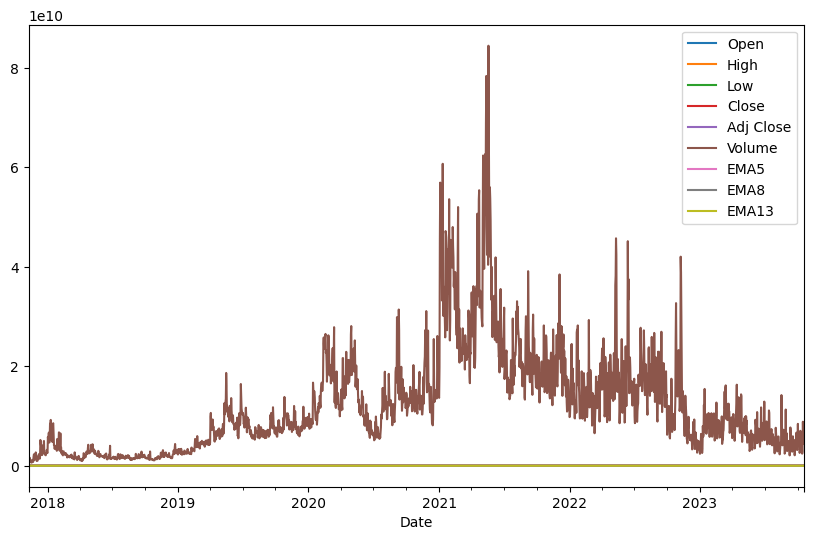

In [13]:
import yfinance as yf
import numpy as np

eth = yf.Ticker("ETH-USD")
df_eth = yf.download(tickers="ETH-USD", period="max", interval="1d")

# Calculate EMA
df_eth['EMA5'] = df_eth['Close'].ewm(span=5).mean()
df_eth['EMA8'] = df_eth['Close'].ewm(span=8).mean()
df_eth['EMA13'] = df_eth['Close'].ewm(span=13).mean()
df_eth.plot(figsize=(10, 6));

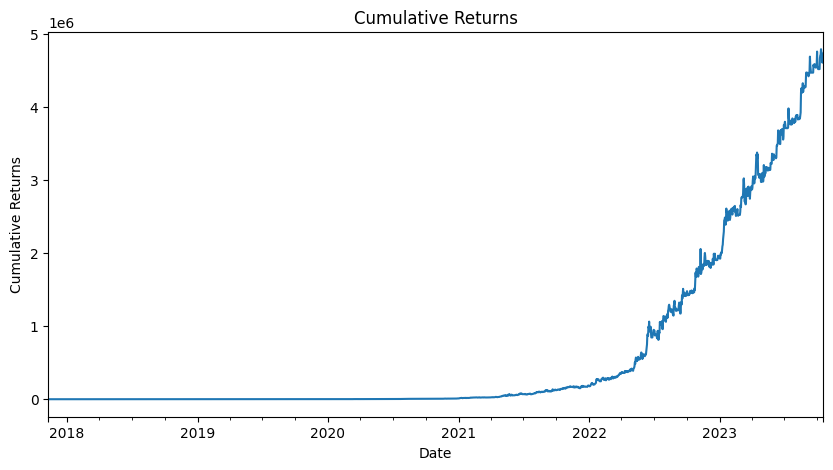

Sharpe Ratio: 2.831945264157932


In [14]:
# Define trading signals
df_eth['Buy_Signal'] = (df_eth['EMA5'] > df_eth['EMA8']) & (df_eth['EMA8'] > df_eth['EMA13'])
df_eth['Sell_Signal'] = (df_eth['EMA5'] < df_eth['EMA8']) & (df_eth['EMA8'] < df_eth['EMA13'])

# Calculate returns
df_eth['Return'] = np.log(df_eth['Close'] / df_eth['Close'].shift(1))
df_eth['Strategy_Return'] = df_eth['Return'] * df_eth['Buy_Signal'] - df_eth['Return'] * df_eth['Sell_Signal']
# Calculate cumulative returns
df_eth['Cumulative_Strategy_Returns'] = (1 + df_eth['Strategy_Return']).cumprod()


import matplotlib.pyplot as plt

# Plot cumulative returns
df_eth['Cumulative_Strategy_Returns'].plot(figsize=(10,5))
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

# Calculate Sharpe Ratio
sharpe_ratio = df_eth['Strategy_Return'].mean() / df_eth['Strategy_Return'].std() * np.sqrt(252)
print(f'Sharpe Ratio: {sharpe_ratio}')

In [15]:
df_eth['Position'] = np.where(df_eth['EMA5'] > df_eth['EMA8']>df_eth['EMA13'], 1, -1)

ax = df_eth.plot(secondary_y='Position', figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));

ValueError: ignored

In [16]:
df_eth

,Open,High,Low,Close,Adj Close,Volume,EMA5,EMA8,EMA13,Buy_Signal,Sell_Signal,Return,Strategy_Return,Cumulative_Strategy_Returns
Date,,,,,,,,,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984,320.884003,320.884003,320.884003,False,False,NaN,NaN,NaN
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984,307.905396,308.716558,309.236535,False,True,-0.069790,0.069790,1.069790e+00
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992,311.114892,311.219770,311.337155,False,True,0.050270,-0.050270,1.016012e+00
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936,309.782794,310.059054,310.272717,False,True,-0.021758,0.021758,1.038119e+00
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984,312.444358,312.126960,311.985742,True,False,0.028204,0.028204,1.067398e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-14,1552.263794,1560.325073,1545.738770,1555.256836,1555.256836,2429214718,1562.540060,1575.308379,1590.465444,False,True,0.002039,-0.002039,4.738697e+06
2023-10-15,1555.076050,1565.760864,1550.554565,1558.069824,1558.069824,2923337883,1561.049982,1571.477589,1585.837499,False,True,0.001807,-0.001807,4.730134e+06
2023-10-16,1558.313477,1628.156250,1555.989624,1600.534302,1600.534302,8846928526,1574.211422,1577.934636,1587.937042,False,True,0.026890,-0.026890,4.602942e+06
